In [2]:
import geopandas as gpd
import pystac_client
import pystac
import pandas as pd
import planetary_computer
import rioxarray as rio
import xarray as xr
import stackstac
import matplotlib.pyplot as plt
from shapely import Point, box
from shapely.geometry import shape
import osmnx as ox
import cartopy.crs as ccrs
from xrspatial.multispectral import true_color
import numpy as np
plt.rcParams['font.family'] = 'DejaVu Sans Mono'
from dask.distributed import Client
client=Client()
print(client.dashboard_link)

http://127.0.0.1:8787/status


In [3]:
### define area of interest 
aoi_geom = shape({"coordinates": [[
    [19.19475654180414,52.727823498032365],
    [19.19475654180414,52.52992257823894],
    [19.553118868416988,52.52992257823894],
    [19.553118868416988,52.727823498032365],
    [19.19475654180414,52.727823498032365]]
                                  ],"type": "Polygon"})

aoi = gpd.GeoDataFrame(geometry=[aoi_geom], crs=4326)

In [4]:
################# sentinel 2 scenes
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(collections=["sentinel-2-l2a"],
                        intersects=aoi_geom,
                        datetime="2020-01-01/2023-12-31",
                        query={"eo:cloud_cover":{'lt':10}})

s2_items = search.item_collection()
s2_items = pystac.ItemCollection(
    [item for item in s2_items if 
     shape(item.to_dict()['geometry']).contains(aoi_geom)]
)

epsg = set([item.properties['proj:epsg'] for item in s2_items])
print(f'found {len(s2_items)} S2 items\nwith the following epsgs: {epsg}')

epsg_code = list(epsg)[0]
prj = ccrs.epsg(epsg_code)
aoi_prj = gpd.GeoDataFrame(geometry=[aoi_geom],crs=4326).to_crs(prj)['geometry'][0]

s2 = (stackstac.stack(planetary_computer.sign(s2_items),
                      epsg=epsg_code,
                      resolution=20)
      .rio.clip_box(*aoi_prj.bounds))

found 81 S2 items
with the following epsgs: {32633, 32634}


c:\Users\s1759665\Miniconda3\envs\xdem_plancomp\lib\site-packages\stackstac\prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(
c:\Users\s1759665\Miniconda3\envs\xdem_plancomp\lib\site-packages\stackstac\accumulate_metadata.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(


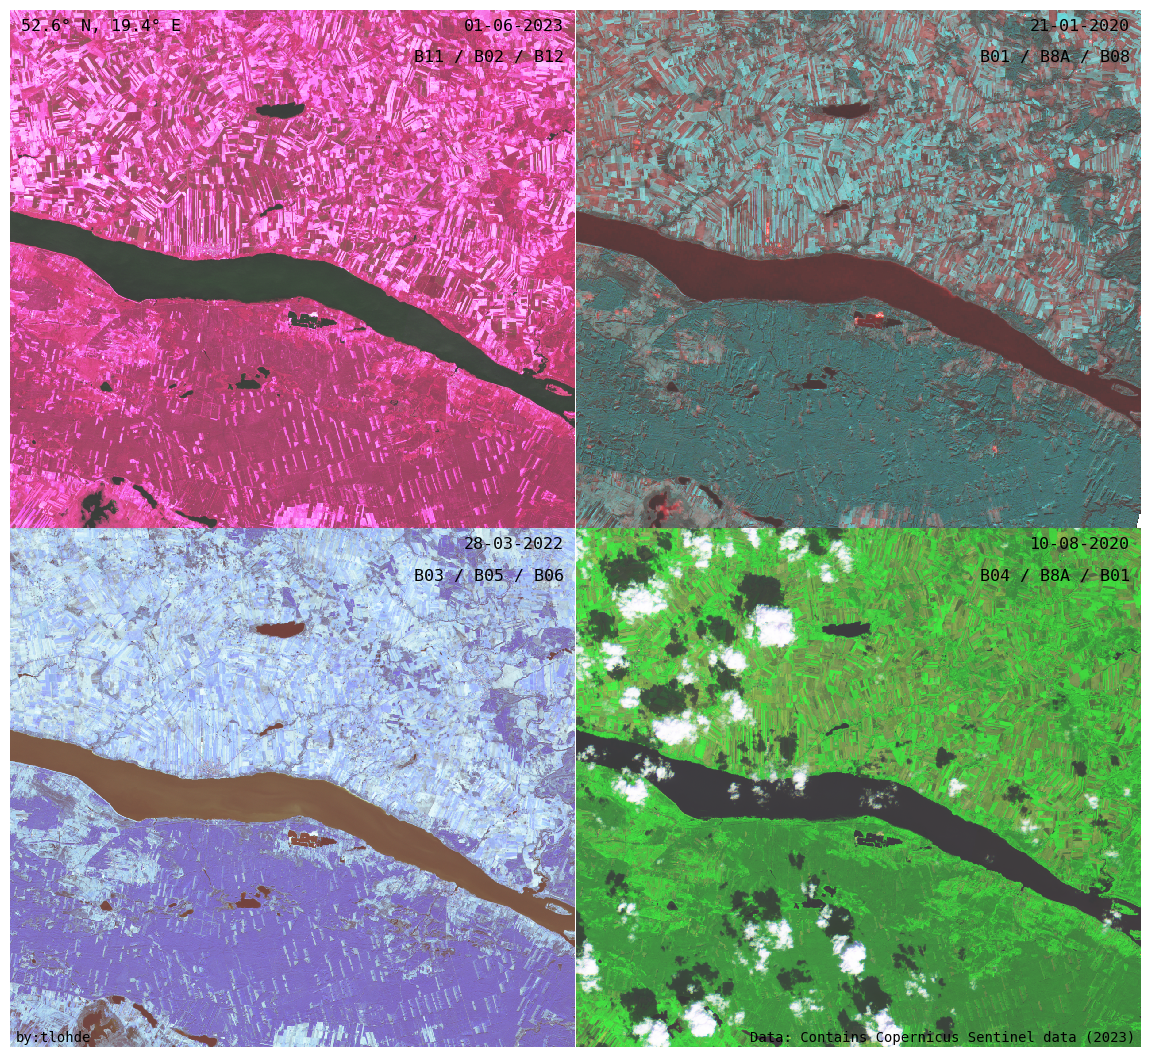

In [19]:
band_sel =[1,2,3,4,5,6,7,8,10,11,12]
time_sel = [i for i in range(len(s2['time']))]
_,_,h,w = s2.shape

fig, axs = plt.subplots(figsize=[w/110,h/110],
                        ncols=2,nrows=2,
                        subplot_kw={'projection':prj})

for ax in axs.flat:
    
    t = np.random.choice(time_sel,1)
    bs = np.random.choice(band_sel,3,replace=False)
    
    true_color(
        *s2[t,bs,:,:].squeeze()
            ).plot.imshow(rgb='band',
                      ax=ax)
    ax.annotate(text=pd.to_datetime(s2['time'][t].values[0]).strftime('%d-%m-%Y'),
                xy=(0.98,0.96),
                ha='right',
                xycoords='axes fraction',
                fontsize=12)
    
    ax.annotate(text=' / '.join(s2['band'][bs].values.tolist()),
                xy=(0.98,0.90),
                xycoords='axes fraction',
                ha='right',
                fontsize=12)
    ax.set_axis_off()
    
axs.flat[-1].annotate(text='Data: Contains Copernicus Sentinel data (2023)',
        xy=(0.99,0.01), 
        xycoords='axes fraction', 
        ha='right', 
        fontsize=10,
        c='k')

axs.flat[-2].annotate(text='by:tlohde',
            xy=(0.01,0.01), 
            xycoords='axes fraction',
            ha='left',
            fontsize=10,
            c='k')

x,y = aoi_geom.centroid.coords.xy
x=x[0]
y=y[0]
if y < 0:
    Y = y * -1
    ns = 'S'
else:
    Y = y
    ns = 'N'
    
if x < 0:
    X = x * -1
    ew = 'W'
else:
    X = x
    ew = 'E'

axs.flat[0].annotate(text=(f'{Y:.1f}° {ns}, {X:.1f}° {ew}'),
                     xy=(0.02,0.96),
                     xycoords='axes fraction',
                     fontsize=12)                

plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)

In [20]:
fig.savefig('day21.png', dpi=300, bbox_inches='tight')